## Preprocess data

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import json_normalize
import json
from collections import Counter
import re

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dense,Flatten, SpatialDropout1D, concatenate
from tensorflow.keras.layers import LSTM,Reshape,TimeDistributed,Bidirectional,Dropout,Masking,Conv1D, Conv2D,MaxPool2D,GlobalAveragePooling1D, GlobalMaxPooling1D, GlobalMaxPool1D, MaxPooling1D
from tensorflow.python.keras.layers.merge import Dot
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
!wget -q http://www.arts.chula.ac.th/ling/wp-content/uploads/TH-Sarabun_Chula1.1.zip -O font.zip
!unzip -qj font.zip TH-Sarabun_Chula1.1/THSarabunChula-Regular.ttf
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('THSarabunChula-Regular.ttf')
mpl.rc('font', family='TH Sarabun Chula')

In [ ]:
# Load data
df_content = pd.read_csv("pantip_scrapping.csv")

In [ ]:
df_content.head()

,topic_id,title,content,tags
0,40643404,ทริปเกาะเสม็ด 3 วัน 2 คืน วันที่สองที่ทรายแก้ว...,\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tคืนแรกที่เ...,"[{'name': 'เกาะเสม็ด', 'slug': 'เกาะเสม็ด'}, {..."
1,40643393,… ธูษิฏา เวลเนส รีสอร์ต ชุมพร Tusita Wellnes...,\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t. ธูษิ...,"[{'name': 'บันทึกนักเดินทาง', 'slug': 'บันทึกน..."
2,40643087,พาชม สนามกอล์ฟ ศูนย์สร้างทางลำปาง กรมทางหลวง (...,\n\nใบสนร่วงให้ฟีลแผ่นดินสีทอง สวยไปอีกแบบครับ...,"[{'name': 'กอล์ฟ', 'slug': 'กอล์ฟ'}, {'name': ..."
3,40642333,Copenhagen : Summer days - ฤดูร้อนในโคเปนเฮเกน...,\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tทริปนี้เป็...,"[{'name': 'โคเปนเฮเกน', 'slug': 'โคเปนเฮเกน'},..."
4,40642260,📌 แจกพิกัด 6 ทุ่งดอกไม้หลากสีทั่วญี่ปุ่น ที่ไม...,\nถ้าพูดถึงดอกไม้ของญี่ปุ่นหลายๆคนคงจะนึกถึงดอ...,"[{'name': 'เที่ยวญี่ปุ่น', 'slug': 'เที่ยวญี่ป..."


## Preprocess labels

In [ ]:
tag_count = []
tags_temp = []

i = 0
for index, row in df_content.iterrows():
  tags = json.loads(json.dumps(eval(row['tags'])))
  temp = []
  for tag in tags:
    temp.append(tag['slug'])
    tag_count.append(tag['slug'])
  tags_temp.append(temp)

df_content['tags'] = tags_temp
tag_count = Counter(tag_count)

In [ ]:
n_tags = int(0.05*len(tag_count))
Top_tags = sorted(tag_count.items(), key=lambda item: item[1], reverse=True)[:n_tags]
print(Top_tags)

[('บันทึกนักเดินทาง', 5099), ('เที่ยวไทย', 2957), ('เที่ยวต่างประเทศ', 2443), ('สถานที่ท่องเที่ยวต่างประเทศ', 1676), ('สถานที่ท่องเที่ยวในประเทศ', 1651), ('Backpack', 1435), ('โรงแรมรีสอร์ท', 1201), ('ภาพถ่ายทิวทัศน์', 1106), ('เที่ยวทะเล', 1067), ('เที่ยวญี่ปุ่น', 950), ('เที่ยวภูเขา', 833), ('ท่องเที่ยว', 727), ('สถานที่ท่องเที่ยว', 582), ('นักท่องเที่ยว', 551), ('One_Day_Trip', 535), ('ร้านอาหาร', 501), ('โรงแรมรีสอร์ทไทย', 467), ('ภาพถ่ายจากกล้องโทรศัพท์', 454), ('คาเฟ่_(Cafe)', 452), ('ประเทศญี่ปุ่น', 450), ('เที่ยวเชิงอนุรักษ์', 442), ('ภาพถ่าย', 426), ('สถานที่ท่องเที่ยวกรุงเทพฯ', 407), ('สถานที่ท่องเที่ยวสำหรับครอบครัว', 393), ('Slow_Life', 389), ('เที่ยวยุโรป', 361), ('เดินป่า', 332), ('แผนการเดินทางและท่องเที่ยว', 330), ('จังหวัดเชียงใหม่', 280), ('ร้านกาแฟ', 260), ('สายการบิน', 245), ('การท่องเที่ยวแห่งประเทศไทย', 214), ('โตเกียว', 193), ('พัทยา', 185), ('เที่ยววัด', 180), ('เที่ยวน้ำตก', 179), ('จังหวัดภูเก็ต', 174), ('ที่พัก', 166), ('โฮมสเตย์', 162), ('สถานที่ถ่ายรูป', 15

In [ ]:
idx_to_tag = {}
tag_to_idx = {}
i = 0
for tag in Top_tags:
  if tag[0] not in tag_to_idx:
    tag_to_idx[tag[0]] = i
    i += 1
idx_to_tag = {v: k for k, v in tag_to_idx.items()}

In [ ]:
print(idx_to_tag)

{0: 'บันทึกนักเดินทาง', 1: 'เที่ยวไทย', 2: 'เที่ยวต่างประเทศ', 3: 'สถานที่ท่องเที่ยวต่างประเทศ', 4: 'สถานที่ท่องเที่ยวในประเทศ', 5: 'Backpack', 6: 'โรงแรมรีสอร์ท', 7: 'ภาพถ่ายทิวทัศน์', 8: 'เที่ยวทะเล', 9: 'เที่ยวญี่ปุ่น', 10: 'เที่ยวภูเขา', 11: 'ท่องเที่ยว', 12: 'สถานที่ท่องเที่ยว', 13: 'นักท่องเที่ยว', 14: 'One_Day_Trip', 15: 'ร้านอาหาร', 16: 'โรงแรมรีสอร์ทไทย', 17: 'ภาพถ่ายจากกล้องโทรศัพท์', 18: 'คาเฟ่_(Cafe)', 19: 'ประเทศญี่ปุ่น', 20: 'เที่ยวเชิงอนุรักษ์', 21: 'ภาพถ่าย', 22: 'สถานที่ท่องเที่ยวกรุงเทพฯ', 23: 'สถานที่ท่องเที่ยวสำหรับครอบครัว', 24: 'Slow_Life', 25: 'เที่ยวยุโรป', 26: 'เดินป่า', 27: 'แผนการเดินทางและท่องเที่ยว', 28: 'จังหวัดเชียงใหม่', 29: 'ร้านกาแฟ', 30: 'สายการบิน', 31: 'การท่องเที่ยวแห่งประเทศไทย', 32: 'โตเกียว', 33: 'พัทยา', 34: 'เที่ยววัด', 35: 'เที่ยวน้ำตก', 36: 'จังหวัดภูเก็ต', 37: 'ที่พัก', 38: 'โฮมสเตย์', 39: 'สถานที่ถ่ายรูป', 40: 'อาหาร', 41: 'เที่ยวจีน', 42: 'ภาคเหนือ', 43: 'รถไฟ', 44: 'จังหวัดกาญจนบุรี', 45: 'ดำน้ำ', 46: 'โอซาก้า', 47: 'มอเตอร์ไซค์', 48: 'ป

In [ ]:
tags_temp = []

for index, row in df_content.iterrows():
  
  temp = []
  for tag in row['tags']:
    # print(tag)
    if tag in tag_to_idx:
      temp.append(tag_to_idx[tag])
  tags_temp.append(temp)
  
df_content['idx_tags'] = tags_temp

In [ ]:
df_content.head()

,topic_id,title,content,tags,idx_tags
0,40643404,ทริปเกาะเสม็ด 3 วัน 2 คืน วันที่สองที่ทรายแก้ว...,\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tคืนแรกที่เ...,"[เกาะเสม็ด, เที่ยวทะเล, จังหวัดระยอง, เที่ยวไท...","[8, 1, 16]"
1,40643393,… ธูษิฏา เวลเนส รีสอร์ต ชุมพร Tusita Wellnes...,\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t. ธูษิ...,"[บันทึกนักเดินทาง, โรงแรมรีสอร์ท, จังหวัดชุมพร...","[0, 6, 8, 16]"
2,40643087,พาชม สนามกอล์ฟ ศูนย์สร้างทางลำปาง กรมทางหลวง (...,\n\nใบสนร่วงให้ฟีลแผ่นดินสีทอง สวยไปอีกแบบครับ...,"[กอล์ฟ, กีฬาผู้สูงอายุ, เที่ยวไทย, จังหวัดลำปา...",[1]
3,40642333,Copenhagen : Summer days - ฤดูร้อนในโคเปนเฮเกน...,\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tทริปนี้เป็...,"[โคเปนเฮเกน, เที่ยวยุโรป, บันทึกนักเดินทาง, ปร...","[25, 0, 3]"
4,40642260,📌 แจกพิกัด 6 ทุ่งดอกไม้หลากสีทั่วญี่ปุ่น ที่ไม...,\nถ้าพูดถึงดอกไม้ของญี่ปุ่นหลายๆคนคงจะนึกถึงดอ...,"[เที่ยวญี่ปุ่น, ฮอกไกโด, โตเกียว, โอซาก้า, สถา...","[9, 61, 32, 46, 3]"


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_content['idx_tags'])

y = multilabel_binarizer.transform(df_content['idx_tags'])

In [ ]:
# Clean text
cut_string = r"[\xa0\|\(\)\[\]\{\}\n\t\r-]*"
df_content['clean_content'] = df_content['title'] + df_content['content']
df_content['clean_content'] = df_content['clean_content'].apply(lambda x: re.sub(cut_string, "", x))

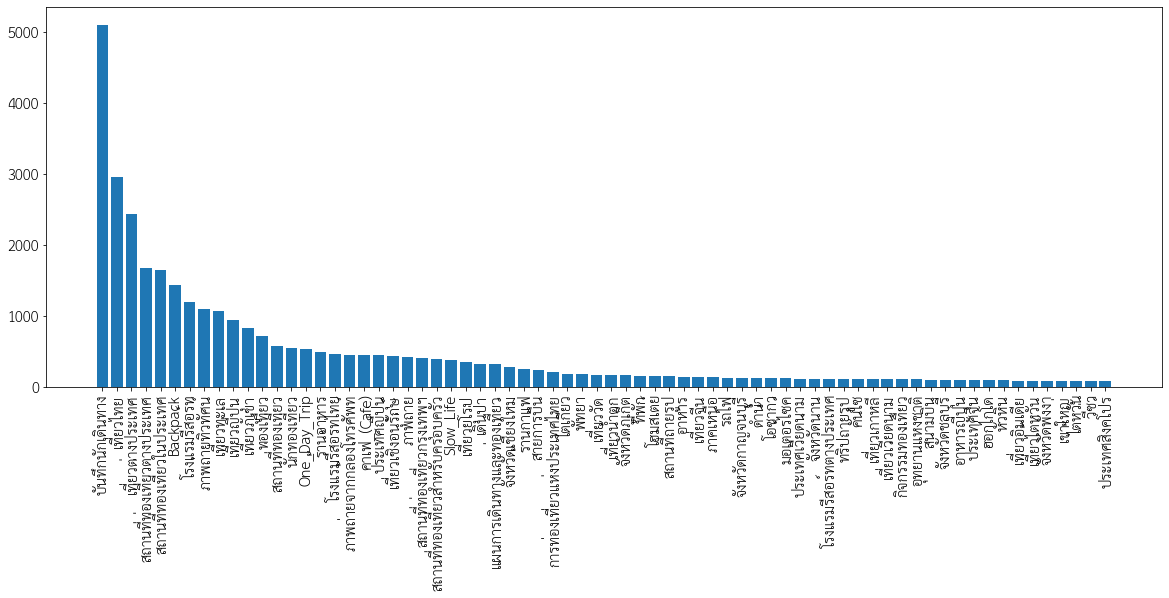

In [ ]:
Tags_ = [i[0] for i in Top_tags]
Count_ = [i[1] for i in Top_tags]

font = {'size': 22}
plt.rc('font', **font)
plt.figure(figsize=(20, 7))
plt.bar(Tags_, Count_)
plt.xticks(rotation=90)
plt.show()

## Tokenizer

In [ ]:
!pip install pythainlp
from pythainlp.tokenize import word_tokenize
from pythainlp.tokenize import syllable_tokenize

In [ ]:
X = df_content['clean_content'].tolist()

In [ ]:
# Tokenize
word_to_idx ={}
idx_to_word ={}

content = df_content['clean_content'].tolist()

new_content = []
for sentence in content:
  text = word_tokenize(sentence, engine="newmm")
  for word in text:
    if word not in word_to_idx:
      word_to_idx[word] = len(word_to_idx) + 1
      idx_to_word[word_to_idx[word]] = word
  new_content.append(text)
word_to_idx['UNK'] = len(word_to_idx)
content_newmm = new_content

del new_content

In [ ]:
vocab_size = len(word_to_idx)

In [ ]:
# content to sequences
content_seq = []
for c in content_newmm:
  temp = []
  for word in c:
    if word in word_to_idx:
      temp.append(word_to_idx[word])
    else:
      temp.append(word_to_idx['UNK'])
  content_seq.append(temp)

In [ ]:
content_lengths = []

for i in content_newmm:
    content_lengths.append(len(i))

In [ ]:
max_length = int(pd.Series(content_lengths).quantile(0.8))

In [ ]:
from keras.preprocessing.sequence import pad_sequences
padded_content = pad_sequences(content_seq, maxlen=max_length, padding='post', truncating='post')

In [ ]:
padded_content.shape, y.shape

((10000, 1288), (10000, 70))

# Model

In [ ]:
from sklearn.model_selection import train_test_split
# Split data
x_train, x_val, y_train, y_val = train_test_split(padded_content, y, 
                                                    test_size=0.4, 
                                                    random_state=9)
x_test, x_val, y_test, y_val = train_test_split(x_val, y_val, 
                                                    test_size=0.5, 
                                                    random_state=9)

## LSTM+CNN

In [ ]:
def get_lstm_cnn_model(max_length, vocab_size, n_tags):
    embedding_dim = 300
    input = Input(shape=(max_length, ))
    x = Embedding(vocab_size, embedding_dim, input_length=max_length, trainable=True)(input)
    x = SpatialDropout1D(0.4)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Conv1D(300, kernel_size = 5, padding = "valid", kernel_initializer = "he_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    concat = concatenate([avg_pool, max_pool])
    dropout = Dropout(0.4)(concat)
    output = Dense(n_tags, activation="sigmoid")(dropout)

    model = Model(inputs=input, outputs=output)
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])
    return model


In [ ]:
model = get_lstm_cnn_model(max_length, vocab_size, n_tags)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1288)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1288, 300)    35844900    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 1288, 300)    0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 1288, 256)    439296      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

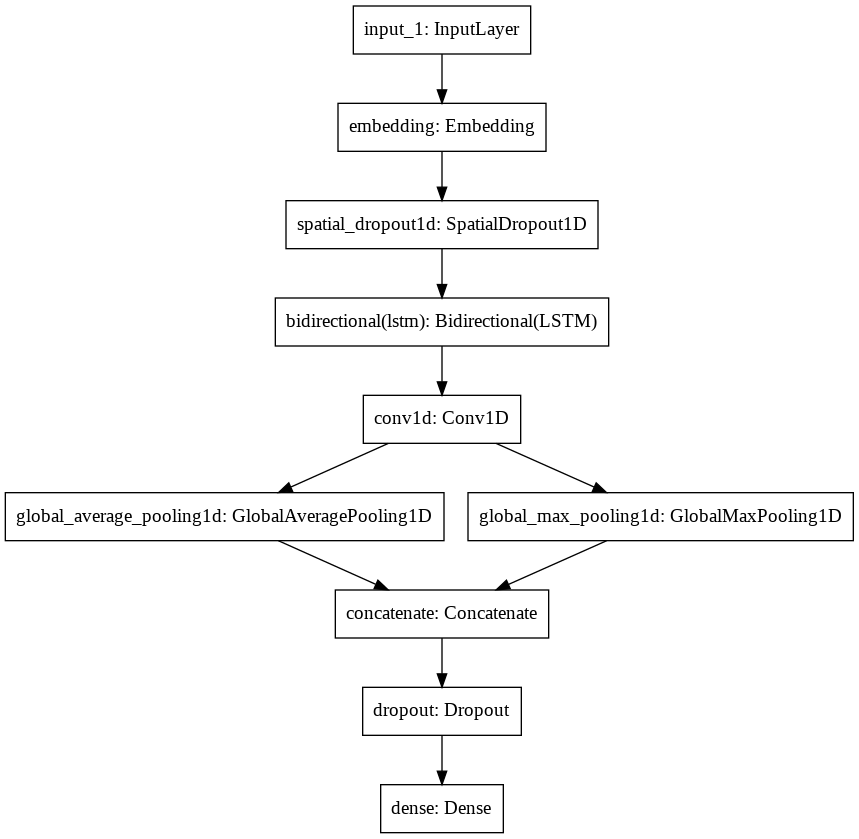

In [ ]:
plot_model(model)

In [ ]:
callbacks = [
             ModelCheckpoint(filepath='model-cnn-lstm.h5', save_best_only=True)
            ]

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/15
47/47 [==============================] - 42s 832ms/step - loss: 0.3512 - accuracy: 0.2521 - val_loss: 0.1562 - val_accuracy: 0.5155
Epoch 2/15
47/47 [==============================] - 38s 811ms/step - loss: 0.1617 - accuracy: 0.4657 - val_loss: 0.1535 - val_accuracy: 0.5170
Epoch 3/15
47/47 [==============================] - 38s 818ms/step - loss: 0.1559 - accuracy: 0.4792 - val_loss: 0.1457 - val_accuracy: 0.4825
Epoch 4/15
47/47 [==============================] - 38s 811ms/step - loss: 0.1452 - accuracy: 0.4131 - val_loss: 0.1361 - val_accuracy: 0.3900
Epoch 5/15
47/47 [==============================] - 38s 812ms/step - loss: 0.1349 - accuracy: 0.3947 - val_loss: 0.1318 - val_accuracy: 0.4435
Epoch 6/15
47/47 [==============================] - 38s 813ms/step - loss: 0.1280 - accuracy: 0.4323 - val_loss: 0.1260 - val_accuracy: 0.4345
Epoch 7/15
47/47 [==============================] - 38s 815ms/step - loss: 0.1198 - accuracy: 0.4422 - val_loss: 0.1222 - val_accuracy: 0.4275

### Predict

In [ ]:
preds = model.predict(x_test)

In [ ]:
print(y_test[0])
print(preds[0])

[1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.15642843 0.00513548 0.05702417 0.07412627 0.02610114 0.04777661
 0.00282676 0.02983481 0.0007136  0.119866   0.00505354 0.09982742
 0.09308866 0.03402109 0.08747964 0.01887841 0.00128716 0.17079918
 0.01579406 0.07502391 0.00681542 0.02626359 0.03522089 0.02370107
 0.02723123 0.00201753 0.00180419 0.04757922 0.00159797 0.01099917
 0.00617298 0.00428687 0.02034601 0.00033542 0.01844261 0.00544675
 0.00378566 0.01181512 0.00182562 0.05685171 0.00943242 0.00127521
 0.00085154 0.01846584 0.00090879 0.00031539 0.00210553 0.00186486
 0.00441759 0.00030834 0.00427633 0.04232186 0.00174661 0.00366715
 0.0021578  0.02093055 0.00018994 0.00918353 0.00533599 0.02006719
 0.00035377 0.0017586  0.00111737 0.0070921  0.00503077 0.00059585
 0.00199674 0.00433086 0.00245848 0.00785224]


In [ ]:
from sklearn.metrics import f1_score

threshold = [i*0.01 for i in range(100)]
f1_score_list = []
for t in threshold:
  preds_int = (preds >= t).astype(int)
  f1_score_list.append(f1_score(y_test, preds_int, average="weighted"))

In [ ]:
len(threshold)
len(f1_score_list)

100

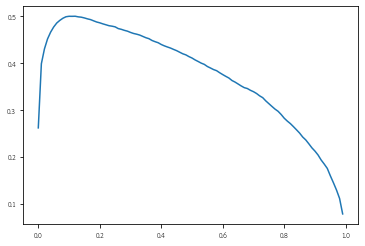

In [ ]:
import matplotlib.pyplot as plt
plt.plot(threshold, f1_score_list)
plt.show()

In [ ]:
# max(f1_score_list)
opt_threshold = threshold[f1_score_list.index(max(f1_score_list))]
print(opt_threshold)
print(max(f1_score_list))

0.12
0.49898503876081046


### Example

In [ ]:
tags_pred = model.predict(padded_content)

In [ ]:
def example_pred(i):
  print(df_content['topic_id'][i])
  print(df_content['title'][i])
  print('=====')
  print(df_content['content'][i][:500])
  print('=====')
  print('Actual Tag')
  print(df_content['tags'][i])
  print('=====')
  print('Predicted Tags')

  tags_pred_idx = tags_pred[i] >= opt_threshold
  tags_pred_i = []
  for j, k in enumerate(tags_pred_idx):
    if k:
      tags_pred_i.append(idx_to_tag[j])
  print(tags_pred_i)
  print('=====')
  print('Corrected')
  corrected_tags = set(tags_pred_i).intersection(set(df_content['tags'][i]))
  print(corrected_tags)
  print('=======================')
  print('=======================\n')

example_pred(501)
example_pred(627)
example_pred(8627)
example_pred(7532)

40482209
[Travelling As A Couple] ทริปพักผ่อนชิลๆ ที่กระบี่ ที่พักดีงาม Pimalai Resort &Spa
=====


หลังจากโควิดระบาดเราก็ไม่ได้นั่งเครื่องบินออกนอกประเทศเลย เลยต้องหาที่เที่ยวในประเทศ ไปเที่ยวพักผ่อนบ้าง สำหรับบ้านเราถ้าให้เลือกระหว่างทะเลกับภูเขา ทะเลก็ยังคงเป็นที่หนึ่งในใจเสมอ

ทริปนี้เลยเลือกมาทะเลทางใต้ดูบ้าง ก่อนหน้าไปหัวหิน พัทยา มาจนเบื่อแล้ว แต่ลงใต้มาหลายที แต่ยังไม่เคยได้แวะเวียนมาเที่ยวกระบี่ซักที และนี่คือครั้งแรกที่เราจะไปเที่ยวกระบี่ ทริปนี้กะไว้แล้วว่าไปเที่ยวแบบพักผ่อนจริงๆ นอนอยู่โรงแรม เล่นน้ำ ทำกิจกรรมภายในโรงแรม ไม่ออกไปไหนเยอะ เพื่อลดความเสี่ยงหลายๆ อย่าง เลยต้องเลือกโร
=====
Actual Tag
['เที่ยวทะเล', 'จังหวัดกระบี่', 'บันทึกนักเดินทาง', 'สถานที่ท่องเที่ยวในประเทศ', 'สถานที่ท่องเที่ยวสำหรับครอบครัว']
=====
Predicted Tags
['บันทึกนักเดินทาง', 'เที่ยวไทย', 'สถานที่ท่องเที่ยวในประเทศ', 'โรงแรมรีสอร์ท', 'เที่ยวทะเล', 'ท่องเที่ยว', 'โรงแรมรีสอร์ทไทย', 'สถานที่ท่องเที่ยวสำหรับครอบครัว', 'จังหวัดภูเก็ต', 'ที่พัก']
=====
Corrected
{'บันทึกนักเดินทาง', 'เที่ยวทะเล', 'สถานท